# 주제 : 홈쇼핑 판매 데이터를 활용하여 판매실적 예측하기

<참고> 데이터 전처리 단계별 파일과 Train, Test 파일을 첨부하였으니 왼쪽 파일에 업로드 하시면 데이터 전처리 시간을 절약 하실 수 있습니다.

# 데이터 설명

###<홈쇼핑 데이터>
*   방송일시 _ 제품이 홈쇼핑에 방영된 날짜 및 시간
*   노출(분) _ 방영된 시간
*   마더코드 _ 상품군에 대한 분류
*   상품코드 _ 상세 품목에 대한 분류
*   상품명 _ 판매되는 상품의 이름
*   상품군 _ 상품에 대한 분류
*   판매단가 _ 상품 1개에 대한 판매 가격
*   취급액 _ 상품에 대한 총 판매액

기간 : 2019년 1월 1일 ~ 12월 31일, 매일 06:00 ~ 23:40 까지의 판매 데이터

출처 : 빅콘테스트 챔피언리그 제공 데이터

###<기상 데이터>


*   최저/최고/평균 기온
*   강수량
* 미세먼지 농도

출처 : 기상청

###<소비자 물가 지수 데이터>
* 소비자 물가 지수

출처 : 통계청







#전처리 전략

*   각 진행 상황별 디버깅을 원활히 하기위해 작업이 완료 될 때마다 현재 상황을 파일로 저장.
* 특성을 선택하기 전 시각화를 통해 그 특성이 유의미한 차이를 드러내는 특성인지 파악 ( 참고자료에 시각화 데이터 첨부. )
* 자주 판매되는 항목을 확인하기 위해 제품명을 단어 단위로 쪼개고 최빈 단어 순으로 정렬, 특성으로 추가
* 핵심전략 : 취급액을 종속 변수로 예측할 경우 취급액 특성의 스케일이 너무 크기 때문에 정확한 예측이 어려워 진다. 따라서 판매 단가와 취급액을 참고하여 판매수량을 구하고 이를 예측하도록 한다. 이러한 방법을 통해 정확도 향상 효과를 기대할 수 있다. (취급액 = 판매단가 * 판매 수량이므로 판매 수량 예측이 곧 취급액 예측이다.)

*   전처리과정은 다음과 같다.

 1. 불필요한 특성 제거
 2. 노출시간 결측치 기입
 3. 상품군이 '무형'인 데이터 삭제
 4. 판매수량 특성 추가
 5. 휴일, 공휴일 특성 추가
 6. 데이터 형변환 (연속형 -> 범주형)
 7. 남여 특성 추가
 8. 무이자, 일시불 특성 추가
 9. 기상 데이터 추가
 10. 물가 데이터 추가
 11. 시각을 범주형 데이터로 변환하여 특성 추가
 12. 특정 상품명 범주형 데이터로 변환하여 특성 추가
 13. Split Train and Test data 


#기타 참고자료(시각화 자료, 빈출 단어 등)는 참고자료 폴더에 첨부.





# 0. 필요한 module import하기

In [ ]:
# -*-coding cp949-*-
import csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 1. 불필요한 특성 제거 _ 마더코드, 상품코드

*   제품의 판매실적을 예측하는데에 마더코드와 상품코드는 불필요한 특성이므로 제거. (보다 일반적인 예측을 가능하도록 하기 위함)



In [ ]:
df= pd.read_csv('실적데이터.csv', encoding='cp949')
del df['마더코드']
del df['상품코드']

df.to_csv('./Preprocessing/01. 코드지우기.csv',encoding='cp949')

# 2. 노출시간 빈칸채우기

*   동일 품목에 대해 연속적으로 편성되었을 경우 맨 처음 편성에만 노출시간이 적혀있어 이후 편성에 노출시간을 기입해주는 과정 필요.



In [ ]:
f = open('./Preprocessing/01. 코드지우기.csv', 'r', encoding='cp949')
rdr1 = csv.reader(f)
w = open('./Preprocessing/02. 노출시간 빈칸채우기.csv', 'w', encoding='cp949', newline='')
wr = csv.writer(w)

for line1 in rdr1:
    if line1[2]=='':
        datetime = line1[1]
        foundtime = 20000
        s = open('./Preprocessing/01. 코드지우기.csv', 'r', encoding='cp949')
        rdr2 = csv.reader(s)
        for line2 in rdr2:
            if line2[1] == datetime:
                foundedtime = line2[2]
                break
        s.close()
        line1[2] = foundedtime
    wr.writerow(line1)

f.close()
w.close()

# 3. 상품군이 '무형'인 데이터 삭제

*   판매 품목의 상품군이 '무형'인 경우(보험, 여행 상품 등) 판매가가 존재하지 않아 예측이 불가하므로 데이터 삭제.





In [ ]:
f = open('./Preprocessing/02. 노출시간 빈칸채우기.csv', 'r', encoding='cp949')
rdr = csv.reader(f)
w = open('./Preprocessing/03. 실적데이터 무형 지우기.csv', 'w', encoding='cp949', newline='')
wr = csv.writer(w)

for line in rdr:
    if line[4] != '무형':
        wr.writerow(line)

f.close()
w.close()

# 4. 판매 수량 특성 추가
* 판매 단가를 float 형식으로 소수점으로 두는 것보다 올림한 int 값을 사용하는 것이 더 정확한 결과를 도출해냈으므로 올림한 값을 사용한다.
*   취급액을 종속 변수로 예측할 경우 취급액 특성의 스케일이 너무 크기 때문에 정확한 예측이 어려워 진다. 따라서 판매 단가와 취급액을 참고하여 판매수량을 구하고 이를 예측하도록 한다. 이러한 방법을 통해 정확도 향상 효과를 기대할 수 있다.
* 취급액 = 판매단가 * 판매 수량이므로 판매 수량 예측이 곧 취급액 예측이다.
 
 *추가 설명 : 
 1.   판매 단가가 높은 경우 판매량이 낮아도 취급액이 높을 수 있다.
 2.   판매 수량이 많을수록 더욱 많은 소비자가 니즈를 느끼고 있다는 것.

 추후 단순히 취급액이 높은 제품을 찾아내기 보다 판매수량이 높은 제품을 찾아내어 마케팅하는 전략도 필요하기 때문에 특성 추가.



In [ ]:
df= pd.read_csv('./Preprocessing/03. 실적데이터 무형 지우기.csv',thousands=',', encoding='cp949')
df['취급액'] = df['취급액'].fillna(value = 0)
df['취급액'] = pd.to_numeric(df['취급액'])
df['판매단가'] = pd.to_numeric(df['판매단가'])
df["판매수량"]=np.ceil(df["취급액"]/df["판매단가"]).astype(int)

df.to_csv('./Preprocessing/04. 실적데이터 판매수량 추가.csv',encoding='cp949')

# 5. 휴일, 공휴일 특성 추가

*   편성일의 휴일, 공휴일 여부가 시청률과 매출액에 영향을 미칠것으로 판단하여 특성 추가



In [ ]:
# 컬럼 정리
raw_sold = pd.read_csv("./Preprocessing/04. 실적데이터 판매수량 추가.csv", encoding='cp949')
sold_data=raw_sold
#인덱스 정렬
col = []
for num, temp in enumerate(sold_data['노출(분)']):
    if pd.isna(temp) :
        col.append(col[num-1])
    else :
        col.append(temp)
sold_data['노출(분)']=col

# 요일 붙여주기
sold_data['방송일시']=pd.to_datetime(sold_data['방송일시'])
sold_data['요일']=sold_data['방송일시'].dt.day_name()

# 요일 바탕으로 휴일 붙여주기
sold_data['휴일'] = ["Yes" if (s=='Saturday')|(s=='Sunday') else "No" for s in sold_data['요일']]
# print(sold_data['방송일시'])

# 공휴일 붙여주기
holidays = ['2019-01-01','2019-02-04','2019-02-05','2019-02-06','2019-03-01','2019-05-06','2019-05-12','2019-06-06','2019-08-15','2019-09-12','2019-09-13','2019-09-14','2019-10-03','2019-10-09','2019-12-25','2020-01-01']
# print(holidays)

#비교 위해 방송일시 date만 남겨서 문자열로 바꾸기
date=sold_data['방송일시'].dt.strftime("%Y-%m-%d")

#holidays랑 비교해서 공휴일 인지 아닌지 리스트로 내보내기
is_hol=[]
for i in date:
    if i in holidays:
        is_hol.append('Yes')
    else:
        is_hol.append('No')

#is_hol을 sold_data에 붙여주기
sold_data['공휴일']=is_hol

#csv로 내보내기
sold_data.to_csv('./Preprocessing/05. 실적데이터(휴일,공휴일 추가).csv',encoding='cp949')

# 6. 데이터 형변환

*   연속형 변수중 범주화가 가능한 특성을 범주형 변수로 형변환

*   판매 단가의 경우 데이터 시각화 후 취급액의 변화를 관찰하여 판매단가를 알맞은 범위로 범주화

* 판매금액에 단위가격을 900원, 9000원 등으로 산정하는 전략을 펼쳤을 경우 매출에 변화가 있을 것으로 예상하여 이를 살펴보기 위해 '단위 가격' 특성 추가 



In [ ]:
train = pd.read_csv('./Preprocessing/05. 실적데이터(휴일,공휴일 추가).csv', encoding='cp949')

# 상품군 숫자형으로 변환 (가나다 순)
train['상품군'] = train['상품군'].map( {'가구': 0, '가전': 1, '건강기능': 2, '농수축': 3, '생활용품': 4, '속옷': 5, '의류': 6, '이미용': 7, '잡화': 8, '주방': 9, '침구': 10} ).astype(int)

# 노출시간 범주형으로 변환
for i in range(train.shape[0]):
    if (train.iloc[i]['노출(분)'] <= 10):
        train.loc[i, '노출(분)'] = 10
    elif (train.iloc[i]['노출(분)'] <= 20):
        train.loc[i, '노출(분)'] = 20
    elif (train.iloc[i]['노출(분)'] <= 30):
        train.loc[i, '노출(분)'] = 30
    elif (train.iloc[i]['노출(분)'] <= 40):
        train.loc[i, '노출(분)'] = 40
    else :
        train.loc[i, '노출(분)'] = 50

# 판매단가 범주형으로 변환

train['판매단가'] = pd.to_numeric(train['판매단가']) # int형으로 변환

for i in range(train.shape[0]):
    if (train.iloc[i]['판매단가'] <= 30900):
        train.loc[i, 'New판매단가'] = 1
    elif (train.iloc[i]['판매단가'] <= 35900):
        train.loc[i, 'New판매단가'] = 2
    elif (train.iloc[i]['판매단가'] <= 42000):
        train.loc[i, 'New판매단가'] = 3
    elif (train.iloc[i]['판매단가'] <= 48000):
        train.loc[i, 'New판매단가'] = 4
    elif (train.iloc[i]['판매단가'] <= 55600):
        train.loc[i, 'New판매단가'] = 5
    elif (train.iloc[i]['판매단가'] <= 60800):
        train.loc[i, 'New판매단가'] = 6
    elif (train.iloc[i]['판매단가'] <= 64800):
        train.loc[i, 'New판매단가'] = 7
    elif (train.iloc[i]['판매단가'] <= 73900):
        train.loc[i, 'New판매단가'] = 8
    elif (train.iloc[i]['판매단가'] <= 95200):
        train.loc[i, 'New판매단가'] = 9
    elif (train.iloc[i]['판매단가'] <= 147000):
        train.loc[i, 'New판매단가'] = 10
    elif (train.iloc[i]['판매단가'] <= 219000):
        train.loc[i, 'New판매단가'] = 11
    elif (train.iloc[i]['판매단가'] > 219000):
        train.loc[i, 'New판매단가'] = 12

#단위가격 특성 추가
train['판매단가'] = train['판매단가'].astype(str) # str형으로 변환
for i in range(train.shape[0]):
    if (train.iloc[i]['판매단가'][-3] == '9'):
        train.loc[i, '단위가격'] = 1
    elif (train.iloc[i]['판매단가'][-3] == '8'):
        train.loc[i, '단위가격'] = 1
    elif (train.iloc[i]['판매단가'][-4] == '9'):
        train.loc[i, '단위가격'] = 1
    elif (train.iloc[i]['판매단가'][-4] == '8'):
        train.loc[i, '단위가격'] = 1
    else:
        train.loc[i, '단위가격'] = 0

train.to_csv('./Preprocessing/06. 숫자형_범주형_변환.csv',encoding='cp949')

# 7, 8. 남/여 특성 및 무이자/일시불 특성 추가 



*   의류의 경우 시각화 결과 남/여 제품에 따라 유의미한 매출액의 차이를 발견 -> 이를 특성으로 추가 (남 = 0, 여 = 1, 이 외 = 2)

* 무이자/일시불에 따라 유의미한 차이를 발견 -> 특성 추가 (무이자 = 0, 일시불 = 1, 이 외 = 2)




In [ ]:
# 컬럼 정리
raw_sold = pd.read_csv("./Preprocessing/06. 숫자형_범주형_변환.csv", encoding='cp949')
sold_data = raw_sold

sold_data.loc[(sold_data['상품명'].str.contains('남성|남자')) & (sold_data['상품군']==6), "남여"] = 0
sold_data.loc[(sold_data['상품명'].str.contains('여성|여자')) & (sold_data['상품군']==6), "남여"] = 1
sold_data['남여'] = sold_data['남여'].fillna(value = 2)

# 무이자/일시불 붙여주기 (무이자=0, 일시불=1)
sold_data.loc[sold_data['상품명'].str.contains('무이자'), "무이자/일시불"] = 0
sold_data.loc[sold_data['상품명'].str.contains('일시불'), "무이자/일시불"] = 1
sold_data['무이자/일시불'] = sold_data['무이자/일시불'].fillna(value = 2)
# csv로 내보내기
sold_data.to_csv('./Preprocessing/07and08. 실적데이터(남여, 무이자일시불 구분).csv', encoding='cp949')

# 9, 10. 기상, 물가 데이터 추가

*   기상 상황에 따라 특정 상품의 판매액에 변화가 있을 것으로 예상하여 특성추가 ( 최저 / 최고 / 평균 기온, 강수량, 미세먼지 농도 등 )
* 당시의 물가 지수와 소비 시장 상황에 따라 판매액에 변화가 있을 것으로 예상하여 특성추가(소비자 물가 지수)


In [ ]:
# 실적데이터 train으로 불러오기
train = pd.read_csv('./Preprocessing/07and08. 실적데이터(남여, 무이자일시불 구분).csv', encoding='cp949')
# 기상데이터 weather으로 불러오기
weather = pd.read_csv('./외부 추가 데이터/일별_기상데이터.csv', encoding='cp949')

train = train.drop(['Unnamed: 0'],axis=1).copy()
train['남여'] = train['남여'].fillna(value = 2)

# train의 방송일시 컬럼 자료형 날짜형으로 변환
train['방송일시'] = pd.to_datetime(train['방송일시'], format='%Y-%m-%d %H:%M:%S', errors='raise')
# weather의 날짜 컬럼 자료형 날짜형으로 변환
weather['날짜'] = pd.to_datetime(weather['날짜'], format='%Y-%m-%d %H:%M:%S', errors='raise')

# train에 평균기온, 강수량 컬럼 추가 (기본값 0.0, double형)
train['최저기온'] = 0.0
train['최고기온'] = 0.0
train['평균기온'] = 0.0
train['강수량'] = 0.0
train['미세먼지농도'] = 0.0

k = 0
# 방송일시의 일에 맞는 기상데이터 넣어주기
for i in range(train.shape[0]):
    for j in range(k,weather.shape[0]):
        if (train.iloc[i]['방송일시'].date() == weather.iloc[j]['날짜'].date()):
            train.loc[i, '최저기온'] = weather.loc[j, '최저기온']
            train.loc[i, '최고기온'] = weather.loc[j, '최고기온']
            train.loc[i, '평균기온'] = weather.loc[j, '평균기온']
            train.loc[i, '강수량'] = weather.loc[j, '강수량']
            train.loc[i, '미세먼지농도'] = weather.loc[j, '미세먼지농도']
            k = j
            break

# 물가지수입력
# 소비자물가지수 CPI로 불러오기
CPI = pd.read_csv('./외부 추가 데이터/월별_소비자물가지수.csv', encoding='cp949')

# train에 소비자물가지수 컬럼 추가 (기본값 0.0, double형)
train['소비자물가지수'] = 0.0

# 방송일시의 월에 맞는 소비자물가지수 넣어주기
for i in range(train.shape[0]):
    for j in range(1, 13):
        if (train.iloc[i]['방송일시'].month == j):
            train.loc[i, '소비자물가지수'] = CPI['소비자물가지수'][j - 1]
            break

train.to_csv('./Preprocessing/09and10. 기상_물가_데이터추가.csv', encoding='cp949')

# 11. 방영 시각을 인덱스로 범주화

*   시각화 결과 방영 시각 별로 유의미한 차이를 발견하여 방영 시각을 범주화하여 인덱싱 후 특성추가



In [ ]:
import pandas as pd

#10 분 간격으로 나누어 index 저장
ts_day_idx = pd.date_range('00:00:00','23:50:00',freq='10T')
series_ts = pd.DataFrame(ts_day_idx, index=range(len(ts_day_idx)))
series_ts.columns = ['시각']
series_ts['시각인덱스'] = series_ts.index
series_ts['시각'] = series_ts['시각'].dt.strftime("%H:%M:%S")

train = pd.read_csv('./Preprocessing/09and10. 기상_물가_데이터추가.csv', header=0,encoding='cp949')
train = train.drop(['Unnamed: 0'],axis=1).copy()

train['방송일시'] = pd.to_datetime(train['방송일시'])
train['시각'] = train['방송일시'].dt.strftime("%H:%M:%S")

total=pd.merge(train,series_ts,on='시각',how='left')
total.to_csv('./Preprocessing/11. 시간추출, 치환.csv', encoding='cp949')

# 12. 특정 상품명 특성 추가

*  편성 횟수와 판매액이 높은 제품 순서대로 정렬 후, 제품명을 word 단위로 split후 wordcloud로 시각화 및 목록 추출
* 이 단어들이 포함된 제품을 따로 특성 추가 
* 단어 갯수는 노출 빈도가 급감하는 범위 전까지 설정. ( 119개 )




In [ ]:
raw_sold = pd.read_csv("./Preprocessing/11. 시간추출, 치환.csv", encoding='cp949')
sold_data = raw_sold

# 무이자/일시불 붙여주기 (무이자=0, 일시불=1)
sold_data.loc[sold_data['상품명'].str.contains('TV'), "New상품명"] = 1
sold_data.loc[sold_data['상품명'].str.contains('쿠쿠전기밥솥'), "New상품명"] = 2
sold_data.loc[sold_data['상품명'].str.contains('침대'), "New상품명"] = 3
sold_data.loc[sold_data['상품명'].str.contains('압력밥솥'), "New상품명"] = 4
sold_data.loc[sold_data['상품명'].str.contains('유로탑'), "New상품명"] = 5
sold_data.loc[sold_data['상품명'].str.contains('드로즈'), "New상품명"] = 6
sold_data.loc[sold_data['상품명'].str.contains('에어컨'), "New상품명"] = 7
sold_data.loc[sold_data['상품명'].str.contains('소파'), "New상품명"] = 8
sold_data.loc[sold_data['상품명'].str.contains('냉장고'), "New상품명"] = 9
sold_data.loc[sold_data['상품명'].str.contains('세탁기'), "New상품명"] = 10
sold_data.loc[sold_data['상품명'].str.contains('침구세트'), "New상품명"] = 11
sold_data.loc[sold_data['상품명'].str.contains('가스레인지'), "New상품명"] = 12
sold_data.loc[sold_data['상품명'].str.contains('노트북'), "New상품명"] = 13
sold_data.loc[sold_data['상품명'].str.contains('분쇄믹서기'), "New상품명"] = 14
sold_data.loc[sold_data['상품명'].str.contains('온수매트'), "New상품명"] = 15
sold_data.loc[sold_data['상품명'].str.contains('브라팬티'), "New상품명"] = 16
sold_data.loc[sold_data['상품명'].str.contains('안동간고등어'), "New상품명"] = 17
sold_data.loc[sold_data['상품명'].str.contains('LED침대'), "New상품명"] = 18
sold_data.loc[sold_data['상품명'].str.contains('트렁크'), "New상품명"] = 19
sold_data.loc[sold_data['상품명'].str.contains('캐리어'), "New상품명"] = 20
sold_data.loc[sold_data['상품명'].str.contains('에어프라이어'), "New상품명"] = 21
sold_data.loc[sold_data['상품명'].str.contains('벽걸이에어컨'), "New상품명"] = 22
sold_data.loc[sold_data['상품명'].str.contains('비데'), "New상품명"] = 23
sold_data.loc[sold_data['상품명'].str.contains('냄비세트'), "New상품명"] = 24
sold_data.loc[sold_data['상품명'].str.contains('데님팬츠'), "New상품명"] = 25
sold_data.loc[sold_data['상품명'].str.contains('소곱창전골'), "New상품명"] = 26
sold_data.loc[sold_data['상품명'].str.contains('선글라스'), "New상품명"] = 27
sold_data.loc[sold_data['상품명'].str.contains('크로스백'), "New상품명"] = 28
sold_data.loc[sold_data['상품명'].str.contains('숄더백'), "New상품명"] = 29
sold_data.loc[sold_data['상품명'].str.contains('토트백'), "New상품명"] = 30
sold_data.loc[sold_data['상품명'].str.contains('손질갑오징어'), "New상품명"] = 31
sold_data.loc[sold_data['상품명'].str.contains('생유산균골드'), "New상품명"] = 32
sold_data.loc[sold_data['상품명'].str.contains('다이아몬드'), "New상품명"] = 33
sold_data.loc[sold_data['상품명'].str.contains('롱코트'), "New상품명"] = 34
sold_data.loc[sold_data['상품명'].str.contains('밍크'), "New상품명"] = 35
sold_data.loc[sold_data['상품명'].str.contains('니트'), "New상품명"] = 36
sold_data.loc[sold_data['상품명'].str.contains('팔찌'), "New상품명"] = 37
sold_data.loc[sold_data['상품명'].str.contains('모시떡'), "New상품명"] = 38
sold_data.loc[sold_data['상품명'].str.contains('쌀'), "New상품명"] = 39
sold_data.loc[sold_data['상품명'].str.contains('가스와이드그릴'), "New상품명"] = 40
sold_data.loc[sold_data['상품명'].str.contains('프라이팬'), "New상품명"] = 41
sold_data.loc[sold_data['상품명'].str.contains('팬츠'), "New상품명"] = 42
sold_data.loc[sold_data['상품명'].str.contains('목걸이'), "New상품명"] = 43
sold_data.loc[sold_data['상품명'].str.contains('패딩'), "New상품명"] = 44
sold_data.loc[sold_data['상품명'].str.contains('무선청소기'), "New상품명"] = 45
sold_data.loc[sold_data['상품명'].str.contains('티셔츠'), "New상품명"] = 46
sold_data.loc[sold_data['상품명'].str.contains('녹용도가니탕'), "New상품명"] = 47
sold_data.loc[sold_data['상품명'].str.contains('손질문어'), "New상품명"] = 48
sold_data.loc[sold_data['상품명'].str.contains('순금'), "New상품명"] = 49
sold_data.loc[sold_data['상품명'].str.contains('포기김치'), "New상품명"] = 50
sold_data.loc[sold_data['상품명'].str.contains('롱드로즈'), "New상품명"] = 51
sold_data.loc[sold_data['상품명'].str.contains('후라이팬'), "New상품명"] = 52
sold_data.loc[sold_data['상품명'].str.contains('런닝'), "New상품명"] = 53
sold_data.loc[sold_data['상품명'].str.contains('언더셔츠'), "New상품명"] = 54
sold_data.loc[sold_data['상품명'].str.contains('통오징어'), "New상품명"] = 55
sold_data.loc[sold_data['상품명'].str.contains('사첼백'), "New상품명"] = 56
sold_data.loc[sold_data['상품명'].str.contains('두유48팩'), "New상품명"] = 57
sold_data.loc[sold_data['상품명'].str.contains('락앤락'), "New상품명"] = 58
sold_data.loc[sold_data['상품명'].str.contains('전기밥솥'), "New상품명"] = 59
sold_data.loc[sold_data['상품명'].str.contains('전자레인지'), "New상품명"] = 60
sold_data.loc[sold_data['상품명'].str.contains('쥐포'), "New상품명"] = 61
sold_data.loc[sold_data['상품명'].str.contains('레깅스'), "New상품명"] = 62
sold_data.loc[sold_data['상품명'].str.contains('석류'), "New상품명"] = 63
sold_data.loc[sold_data['상품명'].str.contains('원피스'), "New상품명"] = 64
sold_data.loc[sold_data['상품명'].str.contains('브라'), "New상품명"] = 65
sold_data.loc[sold_data['상품명'].str.contains('브라탑'), "New상품명"] = 66
sold_data.loc[sold_data['상품명'].str.contains('코트'), "New상품명"] = 67
sold_data.loc[sold_data['상품명'].str.contains('샌들'), "New상품명"] = 68
sold_data.loc[sold_data['상품명'].str.contains('온열매트'), "New상품명"] = 69
sold_data.loc[sold_data['상품명'].str.contains('치마레깅스'), "New상품명"] = 70
sold_data.loc[sold_data['상품명'].str.contains('갓김치3kg+총각김치3kg'), "New상품명"] = 71
sold_data.loc[sold_data['상품명'].str.contains('항균도마'), "New상품명"] = 72
sold_data.loc[sold_data['상품명'].str.contains('핸드백'), "New상품명"] = 73
sold_data.loc[sold_data['상품명'].str.contains('리빙박스'), "New상품명"] = 74
sold_data.loc[sold_data['상품명'].str.contains('반지'), "New상품명"] = 75
sold_data.loc[sold_data['상품명'].str.contains('햅쌀'), "New상품명"] = 76
sold_data.loc[sold_data['상품명'].str.contains('루테인'), "New상품명"] = 77
sold_data.loc[sold_data['상품명'].str.contains('넥센타이어'), "New상품명"] = 78
sold_data.loc[sold_data['상품명'].str.contains('자켓'), "New상품명"] = 79
sold_data.loc[sold_data['상품명'].str.contains('예초기'), "New상품명"] = 80
sold_data.loc[sold_data['상품명'].str.contains('백팩'), "New상품명"] = 81
sold_data.loc[sold_data['상품명'].str.contains('갈비탕'), "New상품명"] = 82
sold_data.loc[sold_data['상품명'].str.contains('손질갈치'), "New상품명"] = 83
sold_data.loc[sold_data['상품명'].str.contains('베스트'), "New상품명"] = 84
sold_data.loc[sold_data['상품명'].str.contains('브라세트'), "New상품명"] = 85
sold_data.loc[sold_data['상품명'].str.contains('밴딩팬츠'), "New상품명"] = 86
sold_data.loc[sold_data['상품명'].str.contains('남성기초세트'), "New상품명"] = 87
sold_data.loc[sold_data['상품명'].str.contains('동태포'), "New상품명"] = 88
sold_data.loc[sold_data['상품명'].str.contains('행주티슈'), "New상품명"] = 89
sold_data.loc[sold_data['상품명'].str.contains('손질새우'), "New상품명"] = 90
sold_data.loc[sold_data['상품명'].str.contains('여행가방'), "New상품명"] = 91
sold_data.loc[sold_data['상품명'].str.contains('스니커즈'), "New상품명"] = 92
sold_data.loc[sold_data['상품명'].str.contains('손질왕꼬막'), "New상품명"] = 93
sold_data.loc[sold_data['상품명'].str.contains('백김치'), "New상품명"] = 94
sold_data.loc[sold_data['상품명'].str.contains('러닝화'), "New상품명"] = 95
sold_data.loc[sold_data['상품명'].str.contains('청소기'), "New상품명"] = 96
sold_data.loc[sold_data['상품명'].str.contains('물걸레'), "New상품명"] = 97
sold_data.loc[sold_data['상품명'].str.contains('갑오징어'), "New상품명"] = 98
sold_data.loc[sold_data['상품명'].str.contains('후드코트'), "New상품명"] = 99
sold_data.loc[sold_data['상품명'].str.contains('워킹화'), "New상품명"] = 100
sold_data.loc[sold_data['상품명'].str.contains('브라캡'), "New상품명"] = 101
sold_data.loc[sold_data['상품명'].str.contains('손질꽃게'), "New상품명"] = 102
sold_data.loc[sold_data['상품명'].str.contains('서랍장'), "New상품명"] = 103
sold_data.loc[sold_data['상품명'].str.contains('꽃게'), "New상품명"] = 104
sold_data.loc[sold_data['상품명'].str.contains('코르셋'), "New상품명"] = 105
sold_data.loc[sold_data['상품명'].str.contains('젤네일스트립'), "New상품명"] = 106
sold_data.loc[sold_data['상품명'].str.contains('다이아'), "New상품명"] = 107
sold_data.loc[sold_data['상품명'].str.contains('LA갈비'), "New상품명"] = 108
sold_data.loc[sold_data['상품명'].str.contains('옷걸이'), "New상품명"] = 109
sold_data.loc[sold_data['상품명'].str.contains('릴렉스팬츠'), "New상품명"] = 110
sold_data.loc[sold_data['상품명'].str.contains('카페트'), "New상품명"] = 111
sold_data.loc[sold_data['상품명'].str.contains('매트릭스'), "New상품명"] = 112
sold_data.loc[sold_data['상품명'].str.contains('트렌치코트'), "New상품명"] = 113
sold_data.loc[sold_data['상품명'].str.contains('반팔'), "New상품명"] = 114
sold_data.loc[sold_data['상품명'].str.contains('공기청정기'), "New상품명"] = 115
sold_data.loc[sold_data['상품명'].str.contains('로봇청소기'), "New상품명"] = 116
sold_data.loc[sold_data['상품명'].str.contains('롱패딩'), "New상품명"] = 117
sold_data.loc[sold_data['상품명'].str.contains('바다장어'), "New상품명"] = 118
sold_data.loc[sold_data['상품명'].str.contains('패션밍크'), "New상품명"] = 119

sold_data['New상품명'] = sold_data['New상품명'].fillna(value = 0)

#공휴일, 휴일여부 renaming
sold_data.loc[sold_data['공휴일'].str.contains('Yes'), "공휴일 여부"] = 1
sold_data.loc[sold_data['공휴일'].str.contains('No'), "공휴일 여부"] = 0
sold_data.loc[sold_data['휴일'].str.contains('Yes'), "휴일 여부"] = 1
sold_data.loc[sold_data['휴일'].str.contains('No'), "휴일 여부"] = 0
sold_data.loc[sold_data['요일'].str.contains('Monday'), "New요일"] = 0
sold_data.loc[sold_data['요일'].str.contains('Tuesday'), "New요일"] = 1
sold_data.loc[sold_data['요일'].str.contains('Wednesday'), "New요일"] = 2
sold_data.loc[sold_data['요일'].str.contains('Thursday'), "New요일"] = 3
sold_data.loc[sold_data['요일'].str.contains('Friday'), "New요일"] = 4
sold_data.loc[sold_data['요일'].str.contains('Saturday'), "New요일"] = 5
sold_data.loc[sold_data['요일'].str.contains('Sunday'), "New요일"] = 6

# csv로 내보내기
sold_data.to_csv('./Preprocessing/12. 상품명 치환.csv', encoding='cp949')

# 학습, 평가 데이터 도출



*   머신러닝을 위해 데이터를 7:3의 비율로 학습, 평가 데이터로 나눔



In [ ]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("./Preprocessing/12. 상품명 치환.csv", sep=",", encoding='cp949')
df = df.drop(['Unnamed: 0'],axis=1).copy()
df = df.drop(['Unnamed: 0.1'],axis=1).copy()
df = df.drop(['Unnamed: 0.1.1'],axis=1).copy()
df = df.drop(['Unnamed: 0.1.1.1'],axis=1).copy()
df = df.drop(['Unnamed: 0.1.1.1.1'],axis=1).copy()
df = df.drop(['Unnamed: 0.1.1.1.1.1'],axis=1).copy()

train, test = train_test_split(df, test_size=0.3)

train.to_csv('./Preprocessing/13_1. 최종train.csv', encoding='cp949')
test.to_csv('./Preprocessing/13_2. 최종test.csv', encoding='cp949')

# 1. 머신러닝 학습 및 평가


# 머신러닝 전략

*   도출한 데이터에 취급액이 Labeling 되어있으므로 Supervised Learing을 진행한다.
*   다양한 특성을 반영하여 취급액을 도출해내는 '회귀' 문제이므로 이에 알맞는 머신러닝 기법인 Linear Regression, Decision Tree, RandomForest, SVM의 기본 하이퍼 파라미터값으로 학습 및 평가(mse, 평균제곱근오차) 후 제일 성능이 좋은 모델 선택
* 모델 하이퍼 파라미터와 데이터의 특성을 조절해가며 모델 세부조정



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager
from matplotlib import rc
import pickle

# 한글사용위한 코드
font_name = font_manager.FontProperties(fname="malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

# 전처리 완료한 실적데이터를 train으로 받아옴
train = pd.read_csv('./Preprocessing/13_1. 최종train.csv', encoding='cp949')
# 실적데이터와 같은 방법으로 전처리 완료한 예측데이터 test로 받아옴
test = pd.read_csv('./Preprocessing/13_2. 최종test.csv', encoding='cp949')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

# warnings 무시
import warnings
warnings.filterwarnings('ignore')

# train데이터의 방송일시(날짜)에서 month, day, hour, minute, 요일 컬럼 만들어줌
train['방송일시']=pd.to_datetime(train['방송일시'])
train["month"] = train["방송일시"].dt.month
train["day"] = train["방송일시"].dt.day
train["hour"] = train["방송일시"].dt.hour
train["minute"] = train["방송일시"].dt.minute
train["dayofweek"] = train["방송일시"].dt.dayofweek

# 시각화 및 모델 조정을 통해 1억 2천만원 이상의 취급액을 가진 품목은 이상치라고 판단, 제거
idx_nm_1 = train[(train['취급액'] >= 120000000)].index
train = train.drop(idx_nm_1)

# test데이터의 방송일시(날짜)에서 month, day, hour, minute, 요일 컬럼 만들어줌
test['방송일시']=pd.to_datetime(test['방송일시'])
test["month"] = test["방송일시"].dt.month
test["day"] = test["방송일시"].dt.day
test["hour"] = test["방송일시"].dt.hour
test["minute"] = test["방송일시"].dt.minute
test["dayofweek"] = test["방송일시"].dt.dayofweek

# 범주형으로 만들어줄 컬럼 지정 (train데이터 안에 있는 컬럼들)
categorical_feature_names = [
                              "노출(분)",
                              "상품군",
                             "남여",
                             "New판매단가",
                             "무이자/일시불",
                             "시각인덱스",
                             "New상품명",
                              "공휴일 여부",
                             "휴일 여부",
                             'dayofweek',
                             "month",
                             "day",
                             "hour",
                             "minute",
                              "New요일",
                              "단위가격"
                             ]

# 위의 컬럼들 범주형으로 변환
for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

# 컬럼들 중 시행착오를 거쳐 최상의 성능을 보이는 조합의 컬럼들만 사용
feature_names = [
                 "노출(분)",
                  "상품군",
                   "판매단가",
                  "남여",
                 "New판매단가",
                 "단위가격",
                   "무이자/일시불",
                 "최저기온",
                 "최고기온",
                 "평균기온",
                 "강수량",
                  "미세먼지농도",
                 "소비자물가지수",
                  "시각인덱스",
                   "New상품명",
                 "공휴일 여부",
                 "휴일 여부",
                 "New요일",
                "dayofweek",
                 "month",
                "day",
                "hour",
                 "minute"
                 ]

# train, test에서 필요한 컬럼들만 사용해서 취급액을 예측할 X값들 지정
X_train = train[feature_names]
X_test = test[feature_names]

# X값들을 활용하여 값을 예측해줄 '판매수량'컬럼 분리
y_train = train["판매수량"]
y_test = test["판매수량"]


* LinearRegression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

#연속형 변수 정규화
sc = StandardScaler()
for col in [x for x in feature_names if x not in categorical_feature_names] :
  X_train[col] = sc.fit_transform(X_train[[col]])
  X_test[col] = sc.fit_transform(X_test[[col]])

model = LinearRegression()
model.fit(X_train, y_train)
from sklearn.metrics import mean_squared_error
some_predicted = model.predict(X_test)
mse = np.sqrt(mean_squared_error(some_predicted, y_test))
print('평균제곱근오차', mse)

평균제곱근오차 275.054670330791


* DecisionTree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

#연속형 변수 정규화
sc = StandardScaler()
for col in [x for x in feature_names if x not in categorical_feature_names] :
  X_train[col] = sc.fit_transform(X_train[[col]])
  X_test[col] = sc.fit_transform(X_test[[col]])

model = DecisionTreeRegressor()
model.fit(X_train, y_train)
from sklearn.metrics import mean_squared_error
some_predicted = model.predict(X_test)
mse = np.sqrt(mean_squared_error(some_predicted, y_test))
print('평균제곱근오차', mse)

평균제곱근오차 276.7981229096676


* RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

#연속형 변수 정규화
sc = StandardScaler()
for col in [x for x in feature_names if x not in categorical_feature_names] :
  X_train[col] = sc.fit_transform(X_train[[col]])
  X_test[col] = sc.fit_transform(X_test[[col]])

model = RandomForestRegressor()
model.fit(X_train, y_train)
from sklearn.metrics import mean_squared_error
some_predicted = model.predict(X_test)
mse = np.sqrt(mean_squared_error(some_predicted, y_test))
print('평균제곱근오차', mse)

평균제곱근오차 205.04510907542044


* Support Vector Machine

In [ ]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler

#연속형 변수 정규화
sc = StandardScaler()
for col in [x for x in feature_names if x not in categorical_feature_names] :
  X_train[col] = sc.fit_transform(X_train[[col]])
  X_test[col] = sc.fit_transform(X_test[[col]])

model = svm.SVR()
model.fit(X_train, y_train)
from sklearn.metrics import mean_squared_error
some_predicted = model.predict(X_test)
mse = np.sqrt(mean_squared_error(some_predicted, y_test))
print('평균제곱근오차', mse)

평균제곱근오차 410.99193474946804


*MSE 기준으로 정확도가 가장 높은 RandomForest 알고리즘을 선정.

*하이퍼 파라미터와 데이터의 특성 조정하며 정확도 향상

#RandomForest 학습 및 평가

데이터 검증

In [ ]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)

    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)

    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)

    # 평균을 낸다.
    mean_difference = difference.mean()

    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)

    return score

rmsle_scorer = make_scorer(rmsle)

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=100,
                              n_jobs=-1,
                              random_state=0)
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
# 0에 근접할수록 좋은 데이터
print("Data Score= {0:.5f}".format(score))

CPU times: user 5.84 s, sys: 1.05 s, total: 6.89 s
Wall time: 2min 8s
Data Score= 0.66788


RandomForest 수행

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

#연속형 변수만 정규화
sc = StandardScaler()
for col in [x for x in feature_names if x not in categorical_feature_names] :
  X_train[col] = sc.fit_transform(X_train[[col]])
  X_test[col] = sc.fit_transform(X_test[[col]])

model = RandomForestRegressor(n_estimators=100, criterion='mse', min_samples_split=2, random_state = 42)
model.fit(X_train, y_train)
from sklearn.metrics import mean_squared_error
predictions = model.predict(X_test)
mse = np.sqrt(mean_squared_error(predictions, y_test))
print('평균제곱근오차', mse)

평균제곱근오차 205.63448122478837


예측한 데이터 시각화

[Text(0.5, 1.0, 'test')]

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


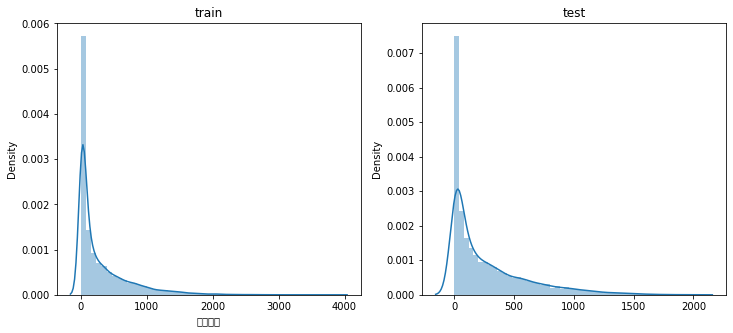

In [ ]:
# 예측한 데이터를 시각화 해본다. 
import seaborn as sns
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")

특성 중요도 시각화

Feature ranking:
1. feature 2 (0.542925)
2. feature 1 (0.086777)
3. feature 13 (0.060574)
4. feature 22 (0.045071)
5. feature 14 (0.035075)
6. feature 4 (0.028530)
7. feature 19 (0.025161)
8. feature 20 (0.017881)
9. feature 21 (0.017591)
10. feature 7 (0.016908)
11. feature 8 (0.016274)
12. feature 11 (0.016063)
13. feature 9 (0.014641)
14. feature 10 (0.013819)
15. feature 17 (0.011493)
16. feature 18 (0.010108)
17. feature 0 (0.010001)
18. feature 12 (0.009564)
19. feature 16 (0.006202)
20. feature 3 (0.005023)
21. feature 15 (0.004194)
22. feature 6 (0.003485)
23. feature 5 (0.002640)


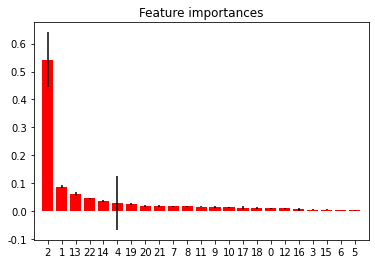

In [ ]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [ ]:
# 특성 중요도

print("특성 중요도 : \n{}".format(model.feature_importances_))

특성 중요도 : 
[0.01000053 0.08677706 0.5429253  0.00502326 0.02852992 0.00264015
 0.00348503 0.01690773 0.01627426 0.01464146 0.01381889 0.01606301
 0.00956443 0.06057418 0.03507459 0.00419403 0.00620212 0.0114928
 0.01010753 0.02516073 0.01788066 0.0175915  0.04507083]


PCA(주성분 분석)를 수행하여 설명력이 좋은 특성들만을 선택한다.

In [ ]:
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

df = pd.DataFrame(X_train, columns=feature_names)

pca = PCA()
pca.fit(df)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

In [ ]:
pca.explained_variance_ratio_

array([5.46470139e-01, 3.26383153e-01, 8.56086518e-02, 2.42196146e-02,
       4.20540851e-03, 3.65290928e-03, 2.87511495e-03, 2.48426758e-03,
       2.11988980e-03, 8.73546535e-04, 3.08442500e-04, 2.14962082e-04,
       1.95182621e-04, 1.53230060e-04, 1.11773245e-04, 5.10419625e-05,
       2.47587688e-05, 2.35052258e-05, 1.29287496e-05, 1.11592612e-05,
       3.10953492e-07, 9.30606522e-09, 1.79157278e-35])

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=11) # 주성분을 몇개로 할지 결정
printcipalComponents_Xtrain = pca.fit_transform(X_train)
principalDf_Xtrain = pd.DataFrame(data=printcipalComponents_Xtrain, columns = ['principal component1', 'principal component2','principal component3', 'principal component4', 'principal component5','principal component6', 'principal component7', 'principal component8','principal component9', 'principal component10', 'principal component11'])
printcipalComponents_Xtest = pca.fit_transform(X_test)
principalDf_Xtest = pd.DataFrame(data=printcipalComponents_Xtest, columns = ['principal component1', 'principal component2','principal component3', 'principal component4', 'principal component5','principal component6', 'principal component7', 'principal component8','principal component9', 'principal component10', 'principal component11'])
# 주성분으로 이루어진 데이터 프레임 구성

3개의 특성으로 데이터의 약 96%, 4개의 특성으로 데이터의 98%를 설명 가능하다.

위 결과들을 바탕으로 특성을 선택하고 다시 학습하여 최종 예측을 한다.

In [ ]:
# train, test에서 필요한 컬럼들만 사용해서 취급액을 예측할 X값들 지정
X_train = principalDf_Xtrain
X_test = principalDf_Xtest

# X값들을 활용하여 값을 예측해줄 '판매수량'컬럼 분리
y_train = train["판매수량"]
y_test = test["판매수량"]

In [ ]:
#특성 수정후 재학습
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

#연속형 변수만 정규화
sc = StandardScaler()
for col in [x for x in X_train.columns if x not in categorical_feature_names] :
  X_train[col] = sc.fit_transform(X_train[[col]])
  X_test[col] = sc.fit_transform(X_test[[col]])

model = RandomForestRegressor(n_estimators=100, criterion='mse', min_samples_split=2, random_state = 42)
model.fit(X_train, y_train)
from sklearn.metrics import mean_squared_error
predictions = model.predict(X_test)
mse = np.sqrt(mean_squared_error(predictions, y_test))
print('평균제곱근오차', mse)

평균제곱근오차 493.3690736819234


PCA를 수행하여 특성의 수를 줄어보려 했지만 특성들간 교호작용(상관관계)와 중요도 등으로 결과가 오히려 악화됨 -> 손수 특성을 줄어가며 개선

In [ ]:
feature_names = [
                #  "노출(분)",
                  "상품군",
                   "판매단가",
                  # "남여",
                 "New판매단가",
                #  "단위가격",
                  #  "무이자/일시불",
                #  "최저기온",
                #  "최고기온",
                #  "평균기온",
                #  "강수량",#10
                  # "미세먼지농도",
                #  "소비자물가지수",
                  "시각인덱스",
                   "New상품명",
                #  "공휴일 여부",
                #  "휴일 여부",
                #  "New요일",
                "dayofweek",
                 "month",
                "day",
                "hour",
                 "minute"
                 ]

# train, test에서 필요한 컬럼들만 사용해서 취급액을 예측할 X값들 지정
X_train = train[feature_names]
X_test = test[feature_names]

# X값들을 활용하여 값을 예측해줄 '판매수량'컬럼 분리
y_train = train["판매수량"]
y_test = test["판매수량"]

In [ ]:
#특성 수정후 재학습
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

#연속형 변수만 정규화
sc = StandardScaler()
for col in [x for x in feature_names if x not in categorical_feature_names] :
  X_train[col] = sc.fit_transform(X_train[[col]])
  X_test[col] = sc.fit_transform(X_test[[col]])

model = RandomForestRegressor(n_estimators=100, criterion='mse', min_samples_split=2, random_state = 42)
model.fit(X_train, y_train)
from sklearn.metrics import mean_squared_error
predictions = model.predict(X_test)
mse = np.sqrt(mean_squared_error(predictions, y_test))
print('평균제곱근오차', mse)

평균제곱근오차 202.8400361472853


205.63448122478837 -> 202.8400361472853 로 개선 되었음을 볼 수 있다.
실험 결과 위에서 선택한 특성들만 고려했을 때 최적이었다.

여러번의 실험을 통해 알아낸 바로는 train and test set을 split 할 때 얼마나 균형잡히게 분리되는지가 정확도에 큰 영향을 미치게 됨을 알 수 있었다. ( 평균제곱근오차가 156으로 산출되는 적도 있었다.)

모델 평가

In [ ]:
# 정확도
print("학습 정확도", model.score(X_train, y_train))
print("테스트 정확도", model.score(X_test, y_test))

# # Cross value
from sklearn.model_selection import cross_val_score
cv_result = cross_val_score(model, X_train, y_train, cv = 5)
print("cross cal scores: ", cv_result)

학습 정확도 0.9702337292616643
테스트 정확도 0.7714733315626213
cross cal scores:  [0.83091019 0.81980718 0.81904113 0.85084549 0.82249987]


#2. 딥러닝 학습 및 평가

모델 선정시 다양한 신경망 모델이 있으나, 우리의 문제(예측, 회귀)를 해결하는 데에는 DNN 모델이 가장 적합하다고 판단하여 DNN을 적용시켜보았다.

 ( CNN = 이미지 분석, RNN = 시계열 분석에 주로 사용되므로 )

In [ ]:
import pandas as pd

# 전처리 완료한 실적데이터를 train으로 받아옴
train = pd.read_csv('./Preprocessing/13_1. 최종train.csv', encoding='cp949')
# 실적데이터와 같은 방법으로 전처리 완료한 예측데이터 test로 받아옴
test = pd.read_csv('./Preprocessing/13_2. 최종test.csv', encoding='cp949')

# train데이터의 방송일시(날짜)에서 month, day, hour, minute, 요일 컬럼 만들어줌
train['방송일시']=pd.to_datetime(train['방송일시'])
train["month"] = train["방송일시"].dt.month
train["day"] = train["방송일시"].dt.day
train["hour"] = train["방송일시"].dt.hour
train["minute"] = train["방송일시"].dt.minute
train["dayofweek"] = train["방송일시"].dt.dayofweek

# 시각화 및 모델 조정을 통해 1억 2천만원 이상의 취급액을 가진 품목은 이상치라고 판단, 제거
idx_nm_1 = train[(train['취급액'] >= 120000000)].index
train = train.drop(idx_nm_1)

# test데이터의 방송일시(날짜)에서 month, day, hour, minute, 요일 컬럼 만들어줌
test['방송일시']=pd.to_datetime(test['방송일시'])
test["month"] = test["방송일시"].dt.month
test["day"] = test["방송일시"].dt.day
test["hour"] = test["방송일시"].dt.hour
test["minute"] = test["방송일시"].dt.minute
test["dayofweek"] = test["방송일시"].dt.dayofweek

# 범주형으로 만들어줄 컬럼 지정 (train데이터 안에 있는 컬럼들)
categorical_feature_names = [
                              "노출(분)",
                              "상품군",
                             "남여",
                             "New판매단가",
                             "무이자/일시불",
                             "시각인덱스",
                             "New상품명",
                              "공휴일 여부",
                             "휴일 여부",
                             'dayofweek',
                             "month",
                             "day",
                             "hour",
                             "minute",
                              "New요일",
                              "단위가격"
                             ]

# 위의 컬럼들 범주형으로 변환
for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

feature_names = [
                 #  "노출(분)",
                  "상품군",
                   "판매단가",
                  # "남여",
                 "New판매단가",
                #  "단위가격",
                  #  "무이자/일시불",
                #  "최저기온",
                #  "최고기온",
                #  "평균기온",
                #  "강수량",#10
                  # "미세먼지농도",
                #  "소비자물가지수",
                  "시각인덱스",
                   "New상품명",
                #  "공휴일 여부",
                #  "휴일 여부",
                #  "New요일",
                "dayofweek",
                 "month",
                "day",
                "hour",
                 "minute"
                 ]

# train, test에서 필요한 컬럼들만 사용해서 취급액을 예측할 X값들 지정
X_train = train[feature_names]
X_test = test[feature_names]

# X값들을 활용하여 값을 예측해줄 '판매수량'컬럼 분리
y_train = train["판매수량"]
y_test = test["판매수량"]

In [ ]:
from keras import layers, models
import tensorflow as tf
from sklearn.preprocessing import StandardScaler


# 각 레이어의 가중치와 바이어스를 초기화하는 옵션이 있음
# keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
# keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)

sc = StandardScaler()
for col in [x for x in feature_names if x not in categorical_feature_names] :
  X_train[col] = sc.fit_transform(X_train[[col]])
  X_test[col] = sc.fit_transform(X_test[[col]])
# X_train = sc.fit_transform(X_train)
# X_test = sc.fit_transform(X_test)

clf = models.Sequential([
    layers.Dense(units=40, input_shape=(10,), activation='relu'),
    layers.Dense(units=30, activation='relu'),
    # layers.Dropout(0.2),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=8, activation='relu'),
    layers.Dense(units=1)
])

clf.compile(optimizer="adam", loss='mse', metrics=['accuracy'])
clf.summary()

clf.fit(X_train, y_train, batch_size=100, epochs=30)

score = clf.evaluate(X_test, y_test, verbose=0)

print(clf.metrics_names)
print(score)

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_266 (Dense)            (None, 40)                440       
_________________________________________________________________
dense_267 (Dense)            (None, 30)                1230      
_________________________________________________________________
dense_268 (Dense)            (None, 16)                496       
_________________________________________________________________
dense_269 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_270 (Dense)            (None, 1)                 9         
Total params: 2,311
Trainable params: 2,311
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
262/262 [==============================] - 1s 2ms/step - loss: 199731.5245 - accuracy: 1.7686e-04
Epoch 2/

결과 : 데이터의 문제인지 모델의 문제인지, loss값은 비정상적으로 높고, 정확도는 너무 낮은 결과가 나왔다. 머신러닝은 정상적으로 된 것으로 보아 모델의 문제일 가능성이 높지만 일주일 간 모델의 변수들을 무수히 바꿔가며 실험해보고 문제점을 검색해본 결과, 명확한 해결법이 나오지 않았다.

따라서 추가로 두번째로 정확도가 높았던 머신러닝 기법인 LinearRegression을 적용시켜보기로 하였다.

In [3]:
import pandas as pd

# 전처리 완료한 실적데이터를 train으로 받아옴
train = pd.read_csv('./Preprocessing/13_1. 최종train.csv', encoding='cp949')
# 실적데이터와 같은 방법으로 전처리 완료한 예측데이터 test로 받아옴
test = pd.read_csv('./Preprocessing/13_2. 최종test.csv', encoding='cp949')

# train데이터의 방송일시(날짜)에서 month, day, hour, minute, 요일 컬럼 만들어줌
train['방송일시']=pd.to_datetime(train['방송일시'])
train["month"] = train["방송일시"].dt.month
train["day"] = train["방송일시"].dt.day
train["hour"] = train["방송일시"].dt.hour
train["minute"] = train["방송일시"].dt.minute
train["dayofweek"] = train["방송일시"].dt.dayofweek

# 시각화 및 모델 조정을 통해 1억 2천만원 이상의 취급액을 가진 품목은 이상치라고 판단, 제거
idx_nm_1 = train[(train['취급액'] >= 120000000)].index
train = train.drop(idx_nm_1)

# test데이터의 방송일시(날짜)에서 month, day, hour, minute, 요일 컬럼 만들어줌
test['방송일시']=pd.to_datetime(test['방송일시'])
test["month"] = test["방송일시"].dt.month
test["day"] = test["방송일시"].dt.day
test["hour"] = test["방송일시"].dt.hour
test["minute"] = test["방송일시"].dt.minute
test["dayofweek"] = test["방송일시"].dt.dayofweek

# 범주형으로 만들어줄 컬럼 지정 (train데이터 안에 있는 컬럼들)
categorical_feature_names = [
                              "노출(분)",
                              "상품군",
                             "남여",
                             "New판매단가",
                             "무이자/일시불",
                             "시각인덱스",
                             "New상품명",
                              "공휴일 여부",
                             "휴일 여부",
                             'dayofweek',
                             "month",
                             "day",
                             "hour",
                             "minute",
                              "New요일",
                              "단위가격"
                             ]

# 위의 컬럼들 범주형으로 변환
for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

feature_names = [
                  #  "노출(분)",
                  "상품군",
                   "판매단가",
                  # "남여",
                 "New판매단가",
                #  "단위가격",
                  #  "무이자/일시불",
                #  "최저기온",
                #  "최고기온",
                #  "평균기온",
                #  "강수량",#10
                  # "미세먼지농도",
                #  "소비자물가지수",
                  "시각인덱스",
                   "New상품명",
                #  "공휴일 여부",
                #  "휴일 여부",
                #  "New요일",
                "dayofweek",
                 "month",
                "day",
                "hour",
                 "minute"
                 ]

# train, test에서 필요한 컬럼들만 사용해서 취급액을 예측할 X값들 지정
X_train = train[feature_names]
X_test = test[feature_names]

# X값들을 활용하여 값을 예측해줄 '판매수량'컬럼 분리
y_train = train["판매수량"]
y_test = test["판매수량"]

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
#연속형 변수 정규화
sc = StandardScaler()
for col in [x for x in feature_names if x not in categorical_feature_names] :
  X_train[col] = sc.fit_transform(X_train[[col]])
  X_test[col] = sc.fit_transform(X_test[[col]])

model = LinearRegression()
model.fit(X_train, y_train)
from sklearn.metrics import mean_squared_error
some_predicted = model.predict(X_test)
mse = np.sqrt(mean_squared_error(some_predicted, y_test))
print('평균제곱근오차', mse)


평균제곱근오차 280.32852764017866


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
# 정확도
print("학습 정확도", model.score(X_train, y_train))
print("테스트 정확도", model.score(X_test, y_test))

# # Cross value
from sklearn.model_selection import cross_val_score
cv_result = cross_val_score(model, X_train, y_train, cv = 5)
print("cross cal scores: ", cv_result)

학습 정확도 0.5863349789751746
테스트 정확도 0.5635202279814872
cross cal scores:  [0.57706018 0.58287283 0.57775524 0.61588056 0.57719907]


단순 선형 회귀 알고리즘이기 때문에 RandomForest 모델 보다 정확도가 현저히 낮은 것을 확인할 수 있다.

# 최종 결과
RandomForest 모델로 학습했을 경우 학습 정확도 0.97, 테스트 정확도 0.77 로 판매실적을 예측 할 수 있다.

#참고 사이트
* PCA _ https://plotly.com/python/pca-visualization/